# Sentiment Analysis with Transformers



In this project, we'll use Hugging Face Transformers to do sentiment analysis. In specific, the Rotten Tomatoes dataset from Hugging Face will be used, and we'll use it to fine-tune a pretrained model.

## Preparation

In [1]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 1.1 MB/s eta 0:00:00a 0:00:01


In [2]:
import numpy as np

import torch
from datasets import load_dataset
import transformers
from transformers import (
    pipeline, 
    AutoTokenizer, 
    AutoModelForSequenceClassification, 
    DataCollatorWithPadding,
    TrainingArguments, 
    Trainer,
    DistilBertTokenizer, 
    DistilBertForSequenceClassification
)

from huggingface_hub import notebook_login

import evaluate

seed = 168

2024-02-13 04:03:11.617107: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-13 04:03:11.617281: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-13 04:03:11.793574: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
notebook_login()

## EDA

Below, we'll load in the data using the Datasets library. The dataset is already split into train, validation and test sets, with 8530, 1066 and 1066 samples. "text" column is the only feature to use and the task is to predict the label column which has binary lables representing positive and negative sentiments.

We also obeserve from the data that the classes are almost perfectly balanced, indicating that we can use accuracy as the performance metric. Further, the reviews range in length from several to 250 characters, thus are not particulary long and should be easy to handle.

In [4]:
dataset = load_dataset("rotten_tomatoes")
dataset

Generating train split:   0%|          | 0/8530 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1066 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1066 [00:00<?, ? examples/s]

Dataset rotten_tomatoes_movie_review downloaded and prepared to /root/.cache/huggingface/datasets/rotten_tomatoes_movie_review/default/1.0.0/40d411e45a6ce3484deed7cc15b82a53dad9a72aafd9f86f8f227134bec5ca46. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 8530
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 1066
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 1066
    })
})

In [5]:
dataset.set_format(type='pandas')
df_train = dataset['train'][:]
df_train

,text,label
0,the rock is destined to be the 21st century's ...,1
1,"the gorgeously elaborate continuation of "" the...",1
2,effective but too-tepid biopic,1
3,if you sometimes like to go to the movies to h...,1
4,"emerges as something rare , an issue movie tha...",1
...,...,...
8525,any enjoyment will be hinge from a personal th...,0
8526,if legendary shlockmeister ed wood had ever ma...,0
8527,hardly a nuanced portrait of a young woman's b...,0
8528,"interminably bleak , to say nothing of boring .",0


<Axes: xlabel='label'>

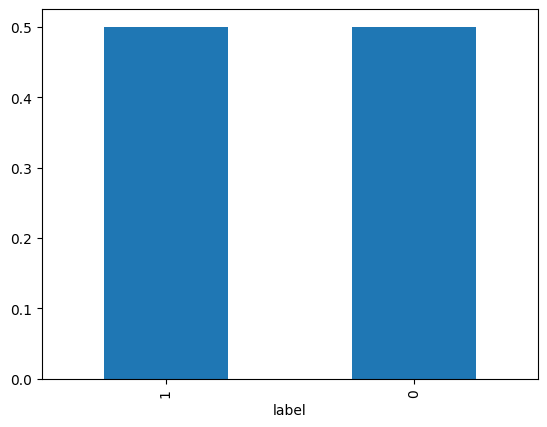

In [6]:
df_train.label.value_counts(normalize=True).plot(kind='bar')

<Axes: ylabel='Frequency'>

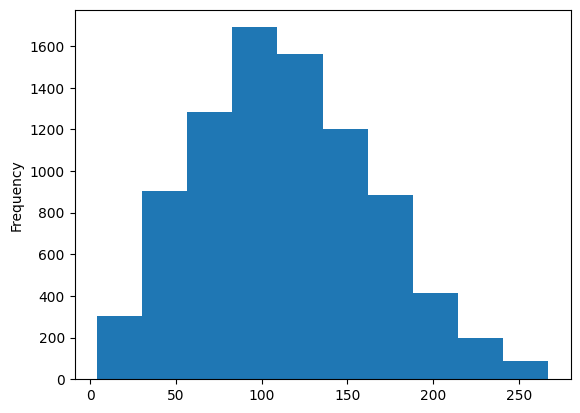

In [7]:
df_train.text.apply(lambda x: len(x)).plot(kind='hist')

## Model Training

Below we experiment with different pretrained transformer models. The model is fined tuned using the training set and evaluated on the validation set. Once the final model is chosen, the model is tested on the test set.

First we start with the "distilbert-base-uncased" model, then swtiched to "michellejieli/NSFW_text_classifier", and finanlly used "distilbert/distilbert-base-uncased-finetuned-sst-2-english". Also, different values are tested for the weight decay and learning rate hyperparameters.

In [8]:
dataset.reset_format()

ds_trn, ds_val, ds_tst = dataset['train'], dataset['validation'], dataset['test']

In [9]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [10]:
def preprocess_function(examples):
    return tokenizer(examples["text"], padding=True, truncation=True)

ds_trn_tokenized = ds_trn.map(preprocess_function, batched=True)
ds_val_tokenized = ds_val.map(preprocess_function, batched=True)
ds_tst_tokenized = ds_tst.map(preprocess_function, batched=True)

  0%|          | 0/9 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

In [11]:
accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

In [12]:
id2label = {0: "NEGATIVE", 1: "POSITIVE"}
label2id = {"NEGATIVE": 0, "POSITIVE": 1}

model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", 
    num_labels=2, 
    id2label=id2label, 
    label2id=label2id
)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [76]:
training_args = TrainingArguments(
    output_dir="trained_model",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=8,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
#     report_to='none',
    push_to_hub=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=ds_trn_tokenized,
    eval_dataset=ds_val_tokenized,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.339044,0.843340
2,0.349500,0.361844,0.845216
3,0.349500,0.430291,0.854597
4,0.140500,0.524861,0.857411
5,0.140500,0.656245,0.845216
6,0.056300,0.753093,0.843340
7,0.056300,0.771190,0.847092
8,0.022900,0.788013,0.848030


Checkpoint destination directory trained_model/checkpoint-267 already exists and is non-empty.Saving will proceed but saved results may be invalid.
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
Checkpoint destination directory trained_model/checkpoint-534 already exists and is non-empty.Saving will proceed but saved results may be invalid.
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
Checkpoint destination directory trained_model/checkpoint-801 already exists and is non-empty.Saving will proceed but saved results may be invalid.
/opt/con

TrainOutput(global_step=2136, training_loss=0.134096723538213, metrics={'train_runtime': 416.5282, 'train_samples_per_second': 163.83, 'train_steps_per_second': 5.128, 'total_flos': 1375673935042560.0, 'train_loss': 0.134096723538213, 'epoch': 8.0})

In [46]:
text = ds_tst[0]['text']
label = ds_tst[0]['label']
text, label

('lovingly photographed in the manner of a golden book sprung to life , stuart little 2 manages sweetness largely without stickiness .',
 1)

In [47]:
classifier = pipeline("sentiment-analysis", model="georgeliu/trained_model")
classifier(text)

config.json:   0%|          | 0.00/735 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

[{'label': 'POSITIVE', 'score': 0.9979475140571594}]

In [84]:
text = ds_tst_tokenized[:10]['text']

inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True).to('cuda')

with torch.no_grad():
    logits = model(**inputs).logits
    
logits

tensor([[-1.0467,  0.9836],
        [-1.7670,  1.8191],
        [ 0.7557, -0.7334],
        [-1.7526,  1.7617],
        [ 0.3621, -0.5309],
        [-0.0764, -0.0051],
        [-1.5490,  1.4408],
        [ 0.4184, -0.4930],
        [-1.4449,  1.4594],
        [-1.8321,  1.8692]], device='cuda:0')

In [103]:
preds = logits.argmax(axis=1).cpu().numpy()
true_labels = np.array(ds_tst_tokenized[:10]['label'])

In [104]:
(preds == true_labels).mean()

0.7

Try a different transformer

In [107]:
model = AutoModelForSequenceClassification.from_pretrained(
    "michellejieli/NSFW_text_classifier", 
    num_labels=2, 
    id2label=id2label, 
    label2id=label2id
)

training_args = TrainingArguments(
    output_dir="trained_model",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=8,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
#     report_to='none',
    push_to_hub=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=ds_trn_tokenized,
    eval_dataset=ds_val_tokenized,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

config.json:   0%|          | 0.00/728 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/268M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.386853,0.826454
2,0.428300,0.376188,0.834897
3,0.428300,0.461067,0.834897
4,0.159700,0.547384,0.845216
5,0.159700,0.691134,0.825516
6,0.069300,0.757261,0.837711
7,0.069300,0.811675,0.836773
8,0.029100,0.828326,0.835835


Checkpoint destination directory trained_model/checkpoint-267 already exists and is non-empty.Saving will proceed but saved results may be invalid.
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
Checkpoint destination directory trained_model/checkpoint-534 already exists and is non-empty.Saving will proceed but saved results may be invalid.
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
Checkpoint destination directory trained_model/checkpoint-801 already exists and is non-empty.Saving will proceed but saved results may be invalid.
/opt/con

TrainOutput(global_step=2136, training_loss=0.1619282660636116, metrics={'train_runtime': 408.0131, 'train_samples_per_second': 167.25, 'train_steps_per_second': 5.235, 'total_flos': 1375673935042560.0, 'train_loss': 0.1619282660636116, 'epoch': 8.0})

In [108]:
model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert/distilbert-base-uncased-finetuned-sst-2-english", 
    num_labels=2, 
    id2label=id2label, 
    label2id=label2id
)

training_args = TrainingArguments(
    output_dir="trained_model",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=8,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
#     report_to='none',
    push_to_hub=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=ds_trn_tokenized,
    eval_dataset=ds_val_tokenized,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.229149,0.915572
2,0.228300,0.276659,0.908068
3,0.228300,0.369389,0.899625
4,0.077400,0.467416,0.903377
5,0.077400,0.582972,0.901501
6,0.026600,0.649142,0.899625
7,0.026600,0.684988,0.901501
8,0.006500,0.694839,0.899625


Checkpoint destination directory trained_model/checkpoint-267 already exists and is non-empty.Saving will proceed but saved results may be invalid.
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
Checkpoint destination directory trained_model/checkpoint-534 already exists and is non-empty.Saving will proceed but saved results may be invalid.
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
Checkpoint destination directory trained_model/checkpoint-801 already exists and is non-empty.Saving will proceed but saved results may be invalid.
/opt/con

TrainOutput(global_step=2136, training_loss=0.07951939805002695, metrics={'train_runtime': 413.2606, 'train_samples_per_second': 165.126, 'train_steps_per_second': 5.169, 'total_flos': 1375673935042560.0, 'train_loss': 0.07951939805002695, 'epoch': 8.0})

In [109]:
model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert/distilbert-base-uncased-finetuned-sst-2-english", 
    num_labels=2, 
    id2label=id2label, 
    label2id=label2id
)

training_args = TrainingArguments(
    output_dir="trained_model",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=16,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
#     report_to='none',
    push_to_hub=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=ds_trn_tokenized,
    eval_dataset=ds_val_tokenized,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.229078,0.914634
2,0.227800,0.282432,0.909944
3,0.227800,0.399891,0.895872
4,0.072300,0.491244,0.898687
5,0.072300,0.660003,0.900563
6,0.023200,0.724354,0.905253
7,0.023200,0.746043,0.902439
8,0.004800,0.797619,0.903377
9,0.004800,0.804541,0.904315
10,0.004700,0.828593,0.903377


Checkpoint destination directory trained_model/checkpoint-267 already exists and is non-empty.Saving will proceed but saved results may be invalid.
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
Checkpoint destination directory trained_model/checkpoint-534 already exists and is non-empty.Saving will proceed but saved results may be invalid.
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
Checkpoint destination directory trained_model/checkpoint-801 already exists and is non-empty.Saving will proceed but saved results may be invalid.
/opt/con

TrainOutput(global_step=4272, training_loss=0.03989523862687389, metrics={'train_runtime': 828.5626, 'train_samples_per_second': 164.719, 'train_steps_per_second': 5.156, 'total_flos': 2751241792676040.0, 'train_loss': 0.03989523862687389, 'epoch': 16.0})

### Tuen Hyperparams

In [13]:
model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert/distilbert-base-uncased-finetuned-sst-2-english", 
    num_labels=2, 
    id2label=id2label, 
    label2id=label2id
)

training_args = TrainingArguments(
    output_dir="trained_model",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=16,
    weight_decay=0.02, #double weight decay
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
#     report_to='none',
    push_to_hub=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=ds_trn_tokenized,
    eval_dataset=ds_val_tokenized,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.229064,0.914634
2,0.227800,0.282265,0.909944
3,0.227800,0.399654,0.896811
4,0.072300,0.489704,0.898687
5,0.072300,0.660518,0.898687
6,0.023000,0.734916,0.903377
7,0.023000,0.740240,0.905253
8,0.005100,0.798883,0.902439
9,0.005100,0.810185,0.906191
10,0.004100,0.853173,0.901501


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead u

TrainOutput(global_step=4272, training_loss=0.03995452179444416, metrics={'train_runtime': 946.7, 'train_samples_per_second': 144.164, 'train_steps_per_second': 4.513, 'total_flos': 2751241792676040.0, 'train_loss': 0.03995452179444416, 'epoch': 16.0})

In [14]:
model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert/distilbert-base-uncased-finetuned-sst-2-english", 
    num_labels=2, 
    id2label=id2label, 
    label2id=label2id
)

training_args = TrainingArguments(
    output_dir="trained_model",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=16,
    weight_decay=0.06, #increase weight decayn even more
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
#     report_to='none',
    push_to_hub=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=ds_trn_tokenized,
    eval_dataset=ds_val_tokenized,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.229071,0.914634
2,0.227900,0.282227,0.909944
3,0.227900,0.399197,0.895872
4,0.072400,0.488451,0.899625
5,0.072400,0.662906,0.896811
6,0.023300,0.730852,0.901501
7,0.023300,0.750276,0.902439
8,0.005100,0.776884,0.903377
9,0.005100,0.792403,0.904315
10,0.003900,0.818650,0.904315


Checkpoint destination directory trained_model/checkpoint-267 already exists and is non-empty.Saving will proceed but saved results may be invalid.
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
Checkpoint destination directory trained_model/checkpoint-534 already exists and is non-empty.Saving will proceed but saved results may be invalid.
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
Checkpoint destination directory trained_model/checkpoint-801 already exists and is non-empty.Saving will proceed but saved results may be invalid.
/opt/con

TrainOutput(global_step=4272, training_loss=0.03994099950689948, metrics={'train_runtime': 790.5985, 'train_samples_per_second': 172.629, 'train_steps_per_second': 5.404, 'total_flos': 2751241792676040.0, 'train_loss': 0.03994099950689948, 'epoch': 16.0})

In [15]:
model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert/distilbert-base-uncased-finetuned-sst-2-english", 
    num_labels=2, 
    id2label=id2label, 
    label2id=label2id
)

training_args = TrainingArguments(
    output_dir="trained_model",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=16,
    weight_decay=0.1, #increase weight decayn even more
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
#     report_to='none',
    push_to_hub=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=ds_trn_tokenized,
    eval_dataset=ds_val_tokenized,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.229106,0.914634
2,0.227900,0.282124,0.909006
3,0.227900,0.398659,0.897749
4,0.072400,0.488253,0.900563
5,0.072400,0.663220,0.897749
6,0.023400,0.726331,0.904315
7,0.023400,0.769138,0.902439
8,0.005500,0.785164,0.904315
9,0.005500,0.799959,0.906191
10,0.003200,0.834503,0.904315


Checkpoint destination directory trained_model/checkpoint-267 already exists and is non-empty.Saving will proceed but saved results may be invalid.
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
Checkpoint destination directory trained_model/checkpoint-534 already exists and is non-empty.Saving will proceed but saved results may be invalid.
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
Checkpoint destination directory trained_model/checkpoint-801 already exists and is non-empty.Saving will proceed but saved results may be invalid.
/opt/con

TrainOutput(global_step=4272, training_loss=0.03975885882555099, metrics={'train_runtime': 795.3472, 'train_samples_per_second': 171.598, 'train_steps_per_second': 5.371, 'total_flos': 2751241792676040.0, 'train_loss': 0.03975885882555099, 'epoch': 16.0})

In [16]:
model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert/distilbert-base-uncased-finetuned-sst-2-english", 
    num_labels=2, 
    id2label=id2label, 
    label2id=label2id
)

training_args = TrainingArguments(
    output_dir="trained_model",
    learning_rate=2e-4, #increase learning rate
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=16,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
#     report_to='none',
    push_to_hub=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=ds_trn_tokenized,
    eval_dataset=ds_val_tokenized,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.300292,0.876173
2,0.294600,0.539936,0.854597
3,0.294600,0.663956,0.837711
4,0.128700,0.656737,0.848968
5,0.128700,0.815004,0.841463
6,0.060000,0.962998,0.839587
7,0.060000,1.079449,0.837711
8,0.023000,1.047117,0.843340
9,0.023000,1.085678,0.852720
10,0.010200,1.158861,0.846154


Checkpoint destination directory trained_model/checkpoint-267 already exists and is non-empty.Saving will proceed but saved results may be invalid.
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
Checkpoint destination directory trained_model/checkpoint-534 already exists and is non-empty.Saving will proceed but saved results may be invalid.
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
Checkpoint destination directory trained_model/checkpoint-801 already exists and is non-empty.Saving will proceed but saved results may be invalid.
/opt/con

TrainOutput(global_step=4272, training_loss=0.06156758411546771, metrics={'train_runtime': 795.7253, 'train_samples_per_second': 171.516, 'train_steps_per_second': 5.369, 'total_flos': 2751241792676040.0, 'train_loss': 0.06156758411546771, 'epoch': 16.0})

In [17]:
model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert/distilbert-base-uncased-finetuned-sst-2-english", 
    num_labels=2, 
    id2label=id2label, 
    label2id=label2id
)

training_args = TrainingArguments(
    output_dir="trained_model",
    learning_rate=2e-6, #reduce learning rate
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=16,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
#     report_to='none',
    push_to_hub=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=ds_trn_tokenized,
    eval_dataset=ds_val_tokenized,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.275820,0.908068
2,0.327500,0.250773,0.910882
3,0.327500,0.247786,0.911820
4,0.237600,0.248846,0.912758
5,0.237600,0.251049,0.912758
6,0.218600,0.255803,0.911820
7,0.218600,0.255105,0.912758
8,0.194600,0.258533,0.911820
9,0.194600,0.262694,0.909944
10,0.187100,0.263872,0.910882


Checkpoint destination directory trained_model/checkpoint-267 already exists and is non-empty.Saving will proceed but saved results may be invalid.
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
Checkpoint destination directory trained_model/checkpoint-534 already exists and is non-empty.Saving will proceed but saved results may be invalid.
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
Checkpoint destination directory trained_model/checkpoint-801 already exists and is non-empty.Saving will proceed but saved results may be invalid.
/opt/con

TrainOutput(global_step=4272, training_loss=0.20352710677443372, metrics={'train_runtime': 789.5258, 'train_samples_per_second': 172.863, 'train_steps_per_second': 5.411, 'total_flos': 2751241792676040.0, 'train_loss': 0.20352710677443372, 'epoch': 16.0})

In [18]:
model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert/distilbert-base-uncased-finetuned-sst-2-english", 
    num_labels=2, 
    id2label=id2label, 
    label2id=label2id
)

training_args = TrainingArguments(
    output_dir="trained_model",
    learning_rate=2e-7, #reduce learning rate
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=16,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
#     report_to='none',
    push_to_hub=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=ds_trn_tokenized,
    eval_dataset=ds_val_tokenized,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.456536,0.907129
2,0.492100,0.425339,0.906191
3,0.492100,0.400295,0.909006
4,0.417200,0.378159,0.909006
5,0.417200,0.359782,0.908068
6,0.380500,0.345173,0.908068
7,0.380500,0.333184,0.909006
8,0.339300,0.323057,0.909006
9,0.339300,0.315095,0.909006
10,0.331600,0.308686,0.909006


Checkpoint destination directory trained_model/checkpoint-267 already exists and is non-empty.Saving will proceed but saved results may be invalid.
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
Checkpoint destination directory trained_model/checkpoint-534 already exists and is non-empty.Saving will proceed but saved results may be invalid.
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
Checkpoint destination directory trained_model/checkpoint-801 already exists and is non-empty.Saving will proceed but saved results may be invalid.
/opt/con

TrainOutput(global_step=4272, training_loss=0.35405352231715054, metrics={'train_runtime': 800.9021, 'train_samples_per_second': 170.408, 'train_steps_per_second': 5.334, 'total_flos': 2751241792676040.0, 'train_loss': 0.35405352231715054, 'epoch': 16.0})

In [19]:
model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert/distilbert-base-uncased-finetuned-sst-2-english", 
    num_labels=2, 
    id2label=id2label, 
    label2id=label2id
)

training_args = TrainingArguments(
    output_dir="trained_model",
    learning_rate=2e-6, #reduce learning rate
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=20, #train for more epochs
    weight_decay=0.05, #use higher weight decay
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
#     report_to='none',
    push_to_hub=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=ds_trn_tokenized,
    eval_dataset=ds_val_tokenized,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.275275,0.908068
2,0.327100,0.250594,0.910882
3,0.327100,0.247583,0.911820
4,0.237000,0.248874,0.912758
5,0.237000,0.251445,0.912758
6,0.216900,0.256591,0.911820
7,0.216900,0.255871,0.912758
8,0.191400,0.260209,0.912758
9,0.191400,0.265658,0.911820
10,0.181700,0.267211,0.910882


Checkpoint destination directory trained_model/checkpoint-267 already exists and is non-empty.Saving will proceed but saved results may be invalid.
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
Checkpoint destination directory trained_model/checkpoint-534 already exists and is non-empty.Saving will proceed but saved results may be invalid.
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
Checkpoint destination directory trained_model/checkpoint-801 already exists and is non-empty.Saving will proceed but saved results may be invalid.
/opt/con

TrainOutput(global_step=5340, training_loss=0.18419504558548946, metrics={'train_runtime': 1000.4625, 'train_samples_per_second': 170.521, 'train_steps_per_second': 5.338, 'total_flos': 3438786400508880.0, 'train_loss': 0.18419504558548946, 'epoch': 20.0})

In [9]:
# Retrain with the tokenizer matching the model

pretrained_model = "distilbert-base-uncased-finetuned-sst-2-english"

tokenizer = DistilBertTokenizer.from_pretrained(pretrained_model)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

def preprocess_function(examples):
    return tokenizer(examples["text"], padding=True, truncation=True)

ds_trn_tokenized = ds_trn.map(preprocess_function, batched=True)
ds_val_tokenized = ds_val.map(preprocess_function, batched=True)
ds_tst_tokenized = ds_tst.map(preprocess_function, batched=True)

accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)


id2label = {0: "NEGATIVE", 1: "POSITIVE"}
label2id = {"NEGATIVE": 0, "POSITIVE": 1}

model = AutoModelForSequenceClassification.from_pretrained(
    pretrained_model, 
    num_labels=2, 
    id2label=id2label, 
    label2id=label2id
)

training_args = TrainingArguments(
    output_dir="trained_model",
    learning_rate=2e-6, #reduce learning rate
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=20, #train for more epochs
    weight_decay=0.05, #use higher weight decay
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
#     report_to='none',
    push_to_hub=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=ds_trn_tokenized,
    eval_dataset=ds_val_tokenized,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

  0%|          | 0/9 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.275275,0.908068
2,0.327100,0.250594,0.910882
3,0.327100,0.247583,0.911820
4,0.237000,0.248874,0.912758
5,0.237000,0.251445,0.912758
6,0.216900,0.256591,0.911820
7,0.216900,0.255871,0.912758
8,0.191400,0.260209,0.912758
9,0.191400,0.265658,0.911820
10,0.181700,0.267211,0.910882


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead u

TrainOutput(global_step=5340, training_loss=0.18419504558548946, metrics={'train_runtime': 1077.3715, 'train_samples_per_second': 158.348, 'train_steps_per_second': 4.957, 'total_flos': 3438786400508880.0, 'train_loss': 0.18419504558548946, 'epoch': 20.0})

## Evaluate Model on Test Set

In [10]:
text = ds_tst_tokenized['text']

inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True).to('cuda')

with torch.no_grad():
    logits = model(**inputs).logits
    
preds = logits.argmax(axis=1).cpu().numpy()
true_labels = np.array(ds_tst_tokenized['label'])

acc = (preds == true_labels).mean()

In [11]:
print(f'Accuracy on test set is {acc :.2%}')

Accuracy on test set is 90.24%


## Summary

The finetuned version of distilbert model ("distilbert/distilbert-base-uncased-finetuned-sst-2-english") was chosen as the final pretrained model for this project. The model provides a ~6 percentage point performance boost. Learning rate turned out to be the most impactful hyperparameter to tune since it improves the model performance by about 2 percentage points while weight decay hardly changes the model's performance. Clearly, model architecture is the dominating factor in improving model performance. The final performance on the test set is 90.24%. To improve the model's performance further in the future, more pretrained models can be tested, also more hyperparameters can be tuned using more extensive value choices.


NOTE: it's discovered after many rounds of training that, the tokenizer was not updated when using different models. Since each model has its own tokenizer, this is problematic and is corrected in the final experiment. But this turned out not to make any difference in the model's performance. This is likely due to the fact the two models are almost the same since one is the fine tuned version of the other, so the tokenizer might also just be the same.